In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%%capture
!unzip /content/gdrive/MyDrive/archive.zip -d /content/training-dataset/

In [3]:
%%capture
!unzip /content/gdrive/MyDrive/test-archive.zip -d /content/testing-dataset

In [4]:
!mv "/content/testing-dataset/development_test_data/gallery" "/content/"
!mv "/content/testing-dataset/development_test_data/queries" "/content/"

!mkdir "/content/original_datasets"
!mv "/content/testing-dataset/development_test_data/gallery.csv" "/content/original_datasets/"
!mv "/content/testing-dataset/development_test_data/queries.csv" "/content/original_datasets/"

!rm -rf "/content/testing-dataset"

!mv "/content/training-dataset/train.csv" "/content/original_datasets/"
!mv "/content/training-dataset/test.csv" "/content/original_datasets/"

!mkdir "/content/train_imgs"

In [5]:
import os
import shutil

train_images = [f for f in os.listdir('/content/training-dataset/train/train')]
for image in train_images:
  shutil.move('/content/training-dataset/train/train/' + image, '/content/train_imgs/' + image)

test_images = [f for f in os.listdir('/content/training-dataset/test/test')]
for image in test_images:
  shutil.move('/content/training-dataset/test/test/' + image, '/content/train_imgs/' + image)

In [6]:
!rm -rf "/content/training-dataset"

In [7]:
!mkdir "/content/generated_datasets"
!cp '/content/gdrive/MyDrive/train_dataset.csv' '/content/generated_datasets/'

## The file and folder structure of data for model building
```
File and folder structure of Product-10K dataset

content
└───gallery
|   |   ambitious-tough-teal-from-asgard.jpg
|   |   fine-shrewd-oarfish-of-genius.jpg
|   |   bold-nickel-gecko-of-reputation.jpg
|   |   marvellous-uber-boobook-of-lightning.jpg
|   |   bouncy-economic-agama-of-honeydew.jpg
│   
└───queries
|   |   magnetic-powerful-platypus-of-hail.jpeg
|   |   free-keen-mole-of-cookies.jpeg
|   |   optimal-uptight-ringtail-of-cleaning.jpeg
|   |   bold-nickel-gecko-of-reputation.jpg
|   |   marvellous-uber-boobook-of-lightning.jpg
|
└───train_imgs
|   |   1.jpg
|   |   10.jpg
|   |   100.jpg
|   |   1000.jpg
|
└───original_datasets
|   |   gallery.csv
|   |   queries.csv
|   |   train.csv
|   |   test.csv
|
└───generated_datasets
```

In [18]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 36.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 62.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 51.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 28.8 MB/s eta 0:00:00


In [19]:
from transformers import AutoImageProcessor, Dinov2Model

model_ckpt = "facebook/dinov2-giant"
image_processor = AutoImageProcessor.from_pretrained(model_ckpt,
                                                     do_normalize=True,
                                                     do_center_crop=True,
                                                     do_rescale=True,
                                                     do_resize=True,
                                                     size={'shortest_edge': 384},
                                                     crop_size={'height':384, 'width':384})
model = Dinov2Model.from_pretrained(model_ckpt)
hidden_dim = model.config.hidden_size

In [20]:
model

Dinov2Model(
  (embeddings): Dinov2Embeddings(
    (patch_embeddings): Dinov2PatchEmbeddings(
      (projection): Conv2d(3, 1536, kernel_size=(14, 14), stride=(14, 14))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): Dinov2Encoder(
    (layer): ModuleList(
      (0-39): 40 x Dinov2Layer(
        (norm1): LayerNorm((1536,), eps=1e-06, elementwise_affine=True)
        (attention): Dinov2Attention(
          (attention): Dinov2SelfAttention(
            (query): Linear(in_features=1536, out_features=1536, bias=True)
            (key): Linear(in_features=1536, out_features=1536, bias=True)
            (value): Linear(in_features=1536, out_features=1536, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (output): Dinov2SelfOutput(
            (dense): Linear(in_features=1536, out_features=1536, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (layer_scale1): Dinov2LayerScale()
        (drop_

In [21]:
image_processor

BitImageProcessor {
  "crop_size": {
    "height": 384,
    "width": 384
  },
  "do_center_crop": true,
  "do_convert_rgb": true,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "BitImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "shortest_edge": 384
  }
}

In [22]:
import torch
model = model.to('cuda')

RuntimeError: ignored

In [12]:
import os
from torch.utils.data import Dataset
from torchvision.io import read_image
import torchvision.transforms as T
import torchvision.transforms.functional as F

class CustomDataset(Dataset):
    def __init__(self, annotations_file, img_dir, indices, transform=None, target_transform=None, crop_to_bbox=False):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.indices = indices
        self.transform = transform
        self.target_transform = target_transform
        self.crop_to_bbox = crop_to_bbox

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, self.indices[0]])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, self.indices[1]]
        if self.transform:
            if not self.crop_to_bbox:
              image = self.transform(image)
            else:
              x = self.img_labels.iloc[idx, self.indices[2]]
              y = self.img_labels.iloc[idx, self.indices[3]]
              w = self.img_labels.iloc[idx, self.indices[4]]
              h = self.img_labels.iloc[idx, self.indices[5]]
              image = self.transform(image, x, y, w, h)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label, img_path

def image_transformation(image):
    images = F.resize(image, (384, 384), antialias=True)
    images = image_processor(images, return_tensors="pt")
    return images

def image_transform_with_bbox_crop(image, x, y, w, h):
    images = F.crop(image, y, x, h, w)
    images = F.resize(images, (384, 384), antialias=True)
    images = image_processor(images, return_tensors="pt")
    return images

In [13]:
import pandas as pd
gallery = pd.read_csv("original_datasets/gallery.csv")
gallery.head()

,seller_img_id,img_path,product_id
0,0,gallery/ambitious-tough-teal-from-asgard.jpg,5019
1,1,gallery/fine-shrewd-oarfish-of-genius.jpg,5008
2,2,gallery/bold-nickel-gecko-of-reputation.jpg,9
3,3,gallery/marvellous-uber-boobook-of-lightning.jpg,3589
4,4,gallery/bouncy-economic-agama-of-honeydew.jpg,3656


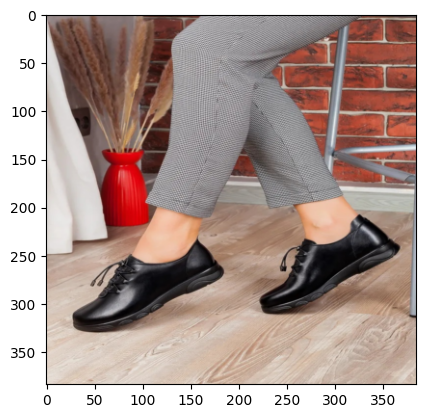

In [14]:
# test image preprocessing
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms.functional as F

proc = AutoImageProcessor.from_pretrained(model_ckpt,
                                          do_normalize=True,
                                          do_center_crop=True,
                                          do_rescale=True,
                                          do_resize=True,
                                          size={'shortest_edge': 384},
                                          crop_size={'height':384, 'width':384})
img = read_image(gallery.iloc[0, 1])
img_ = F.to_pil_image(F.resize(img, (384, 384), antialias=True))
plt.imshow(np.asarray(img_))

torch.Size([3, 384, 384])


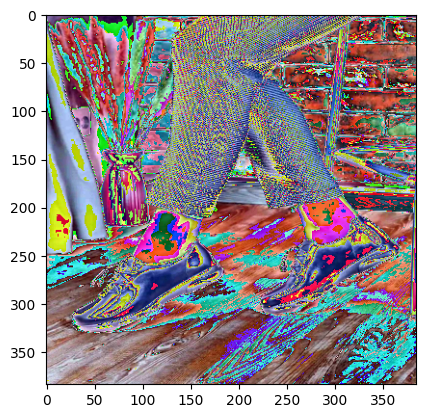

In [15]:
proc_img = proc(img_, return_tensors="pt")
proc_img = torch.squeeze(proc_img['pixel_values'], dim=0)
print(proc_img.shape)
proc_img = F.to_pil_image(proc_img)
plt.imshow(np.asarray(proc_img))

### Generate embeddings for gallery images and save

In [16]:
from tqdm import tqdm
from torch.utils.data import DataLoader

gallery_dataset = CustomDataset("original_datasets/gallery.csv", "", [1, 2], transform=image_transformation)
gallery_dataloader = DataLoader(gallery_dataset, batch_size=32, shuffle=True)

df = pd.DataFrame(columns=['tensor_path', 'label', 'image_path'])

if not os.path.exists("gallery_tensors"):
    os.makedirs("gallery_tensors")

for idx, data in enumerate(tqdm(gallery_dataloader)):
    images, labels, img_paths = data
    images = images['pixel_values'].to('cuda')
    images = torch.squeeze(images, dim=1)

    with torch.no_grad():
        output = model(images)
        embeddings = output.last_hidden_state[:, 0].cpu()

    for i in range(embeddings.shape[0]):
        file_path = f'gallery_tensors/{idx}_{i}.pt'
        torch.save(embeddings[i], file_path)
        df.loc[len(df)] = [file_path, labels[i].item(), img_paths[i]]

df.reset_index(inplace = True)
df.to_csv('gallery_tensors/gallery_tensors.csv', index=False)

100%|██████████| 34/34 [03:01<00:00,  5.35s/it]


In [17]:
class TensorDataset(Dataset):
    def __init__(self, annotations_file, tensor_dir, transform=None, target_transform=None):
        self.tensor_labels = pd.read_csv(annotations_file)
        self.tensor_dir = tensor_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.tensor_labels)

    def __getitem__(self, idx):
        tensor_path = os.path.join(self.tensor_dir, self.tensor_labels.iloc[idx, 1])
        tensor = torch.load(tensor_path)
        label = self.tensor_labels.iloc[idx, 2]
        image_path = self.tensor_labels.iloc[idx, 3]
        if self.transform:
            tensor = self.transform(tensor)
        if self.target_transform:
            label = self.target_transform(label)
        return tensor, label, image_path

In [18]:
gallery_tensors = pd.read_csv("gallery_tensors/gallery_tensors.csv")
gallery_tensors.head()

,index,tensor_path,label,image_path
0,0,gallery_tensors/0_0.pt,3590,gallery/cautious-adamant-termite-of-diversity.jpg
1,1,gallery_tensors/0_1.pt,5250,gallery/fresh-crafty-aardwolf-of-devotion.jpg
2,2,gallery_tensors/0_2.pt,5061,gallery/determined-light-marmot-of-examination...
3,3,gallery_tensors/0_3.pt,5225,gallery/jumping-flat-vole-from-wonderland.jpg
4,4,gallery_tensors/0_4.pt,5006,gallery/logical-didactic-skylark-from-hyperbor...


In [19]:
tensor_dataset = TensorDataset("gallery_tensors/gallery_tensors.csv", "")
tensor_dataloader = DataLoader(tensor_dataset, batch_size=32, shuffle=True)

tensor_dict = {}
label_dict = {}
image_path_dict = {}

for idx, data in enumerate(tqdm(tensor_dataloader)):
    tensors, labels, image_paths = data
    tensor_dict[idx] = tensors
    label_dict[idx] = labels
    image_path_dict[idx] = image_paths

100%|██████████| 34/34 [00:00<00:00, 86.35it/s]


In [20]:
query = pd.read_csv("original_datasets/queries.csv")
query.head()

,user_img_id,img_path,bbox_x,bbox_y,bbox_w,bbox_h,product_id
0,0,queries/magnetic-powerful-platypus-of-hail.jpeg,0,212,740,664,5013
1,1,queries/free-keen-mole-of-cookies.jpeg,0,43,714,378,3550
2,2,queries/hilarious-precious-parakeet-of-adverti...,240,310,395,405,71
3,3,queries/optimal-uptight-ringtail-of-cleaning.jpeg,0,242,475,627,3566
4,4,queries/nonchalant-impala-of-fabulous-artistry...,350,125,150,81,5329


In [21]:
# use this command to see the available RAM space
!free -g

               total        used        free      shared  buff/cache   available
Mem:              50           4           1           0          44          46
Swap:              0           0           0


### Generate embeddings for query images(without cropping to bounding box) and save

In [24]:
query_dataset = CustomDataset("original_datasets/queries.csv", "", [1, 6], transform=image_transformation)
query_dataloader = DataLoader(query_dataset, batch_size=32, shuffle=False)

df = pd.DataFrame(columns=['tensor_path', 'label', 'image_path'])

if not os.path.exists("query_tensors"):
    os.makedirs("query_tensors")

for idx, data in enumerate(tqdm(query_dataloader)):
    images, labels, img_paths = data
    images = images['pixel_values'].to('cuda')
    images = torch.squeeze(images, dim=1)

    with torch.no_grad():
        output = model(images)
        embeddings = output.last_hidden_state[:, 0].cpu()

    for i in range(embeddings.shape[0]):
        file_path = f'query_tensors/{idx}_{i}.pt'
        torch.save(embeddings[i], file_path)
        df.loc[len(df)] = [file_path, labels[i].item(), img_paths[i]]

df.reset_index(inplace = True)
df.to_csv('query_tensors/query_tensors.csv', index=False)

100%|██████████| 61/61 [05:28<00:00,  5.39s/it]


In [25]:
query_tensors = pd.read_csv("query_tensors/query_tensors.csv")
query_tensors.head()

,index,tensor_path,label,image_path
0,0,query_tensors/0_0.pt,5013,queries/magnetic-powerful-platypus-of-hail.jpeg
1,1,query_tensors/0_1.pt,3550,queries/free-keen-mole-of-cookies.jpeg
2,2,query_tensors/0_2.pt,71,queries/hilarious-precious-parakeet-of-adverti...
3,3,query_tensors/0_3.pt,3566,queries/optimal-uptight-ringtail-of-cleaning.jpeg
4,4,query_tensors/0_4.pt,5329,queries/nonchalant-impala-of-fabulous-artistry...


In [26]:
torch.cuda.empty_cache()

### Generate embeddings for query images(with cropping to bounding box) and save

In [27]:
query_dataset = CustomDataset("original_datasets/queries.csv", "", [1, 6, 2, 3, 4, 5], transform=image_transform_with_bbox_crop, crop_to_bbox=True)
query_dataloader = DataLoader(query_dataset, batch_size=32, shuffle=False)

df = pd.DataFrame(columns=['tensor_path', 'label', 'image_path'])

if not os.path.exists("query_tensors_cropped"):
    os.makedirs("query_tensors_cropped")

for idx, data in enumerate(tqdm(query_dataloader)):
    images, labels, img_paths = data
    images = images['pixel_values'].to('cuda')
    images = torch.squeeze(images, dim=1)

    with torch.no_grad():
        output = model(images)
        embeddings = output.last_hidden_state[:, 0].cpu()

    for i in range(embeddings.shape[0]):
        file_path = f'query_tensors_cropped/{idx}_{i}.pt'
        torch.save(embeddings[i], file_path)
        df.loc[len(df)] = [file_path, labels[i].item(), img_paths[i]]

df.reset_index(inplace = True)
df.to_csv('query_tensors_cropped/query_tensors.csv', index=False)

100%|██████████| 61/61 [05:27<00:00,  5.37s/it]


In [28]:
cropped_query_tensors = pd.read_csv("query_tensors_cropped/query_tensors.csv")
cropped_query_tensors.head()

,index,tensor_path,label,image_path
0,0,query_tensors_cropped/0_0.pt,5013,queries/magnetic-powerful-platypus-of-hail.jpeg
1,1,query_tensors_cropped/0_1.pt,3550,queries/free-keen-mole-of-cookies.jpeg
2,2,query_tensors_cropped/0_2.pt,71,queries/hilarious-precious-parakeet-of-adverti...
3,3,query_tensors_cropped/0_3.pt,3566,queries/optimal-uptight-ringtail-of-cleaning.jpeg
4,4,query_tensors_cropped/0_4.pt,5329,queries/nonchalant-impala-of-fabulous-artistry...


### Load the saved query image embedding tensors(non-cropped)

In [29]:
query_tensor_dataset = TensorDataset("query_tensors/query_tensors.csv", "")
query_tensor_dataloader = DataLoader(query_tensor_dataset, batch_size=1, shuffle=False)

query_tensor_dict = {}
query_label_dict = {}
query_image_path_dict = {}

for idx, data in enumerate(tqdm(query_tensor_dataloader)):
    tensors, labels, image_paths = data
    query_tensor_dict[idx] = tensors
    query_label_dict[idx] = labels
    query_image_path_dict[idx] = image_paths

100%|██████████| 1935/1935 [00:01<00:00, 1800.19it/s]


### Load the saved query image embedding tensors(cropped)

In [30]:
crop_query_tensor_dataset = TensorDataset("query_tensors_cropped/query_tensors.csv", "")
crop_query_tensor_dataloader = DataLoader(crop_query_tensor_dataset, batch_size=1, shuffle=False)

crop_query_tensor_dict = {}
crop_query_label_dict = {}
crop_query_image_path_dict = {}

for idx, data in enumerate(tqdm(crop_query_tensor_dataloader)):
    tensors, labels, image_paths = data
    crop_query_tensor_dict[idx] = tensors
    crop_query_label_dict[idx] = labels
    crop_query_image_path_dict[idx] = image_paths

100%|██████████| 1935/1935 [00:01<00:00, 1885.56it/s]


In [31]:
torch.cuda.empty_cache()

In [32]:
batch_size = 32

def AP(actual_label, predicted_labels):
    GPTs = predicted_labels.count(actual_label)
    if GPTs < 1:
        return 1
    AP = 0
    GPTs_found = 0
    for i in range(len(predicted_labels)):
        if predicted_labels[i] == actual_label:
            GPTs_found += 1
            AP += GPTs_found / (i + 1)
    return AP / GPTs

def mAP(APs):
    return np.average(APs)

def zero_shot_model(query_tensor_dictionary):
    APs_euclidean = []
    APs_manhattan = []
    APs_cosine = []
    for i in tqdm(range(len(query_tensor_dictionary))):
        query_tensor_ = query_tensor_dictionary[i].to('cuda')
        query_tensor = query_tensor_.repeat(batch_size, 1)

        euclidean = None
        manhattan = None
        cosine = None
        pred_labels = None
        act_label = query_label_dict[i]
        for k in range(len(tensor_dict)):
            if tensor_dict[k].shape[0] < batch_size:
                query_tensor = query_tensor_.repeat(tensor_dict[k].shape[0], 1)
            gallery_tensors = tensor_dict[k].to('cuda')
            gallery_labels = label_dict[k].to('cuda')
            if euclidean == None and manhattan == None and cosine == None:
                euclidean = torch.nn.functional.pairwise_distance(gallery_tensors, query_tensor, p=2)
                manhattan = torch.nn.functional.pairwise_distance(gallery_tensors, query_tensor, p=1)
                cosine = torch.nn.functional.cosine_similarity(gallery_tensors, query_tensor)
                pred_labels = gallery_labels
            else:
                euclidean = torch.cat((euclidean, torch.nn.functional.pairwise_distance(gallery_tensors, query_tensor, p=2)), dim=0)
                manhattan = torch.cat((manhattan, torch.nn.functional.pairwise_distance(gallery_tensors, query_tensor, p=1)), dim=0)
                cosine = torch.cat((cosine, torch.nn.functional.cosine_similarity(gallery_tensors, query_tensor)), dim=0)
                pred_labels = torch.cat((pred_labels, gallery_labels), dim=0)

        euclidean_, euclidean_indices = torch.sort(euclidean)
        manhattan_, manhattan_indices = torch.sort(manhattan)
        cosine_, cosine_indices = torch.sort(torch.abs(cosine), descending=True)

        pred_labels_euclidean = pred_labels[euclidean_indices]
        pred_labels_manhattan = pred_labels[manhattan_indices]
        pred_labels_cosine = pred_labels[cosine_indices]

        APs_euclidean.append(AP(act_label.item(), pred_labels_euclidean.cpu().numpy().astype(int).tolist()))
        APs_manhattan.append(AP(act_label.item(), pred_labels_manhattan.cpu().numpy().astype(int).tolist()))
        APs_cosine.append(AP(act_label.item(), pred_labels_cosine.cpu().numpy().astype(int).tolist()))

    print('\nEuclidean distance mAP:', mAP(APs_euclidean))
    print('Manhattan distance mAP:', mAP(APs_manhattan))
    print('Cosine distance mAP:', mAP(APs_cosine))

In [33]:
zero_shot_model(query_tensor_dict)

100%|██████████| 1935/1935 [00:28<00:00, 68.40it/s]


Euclidean distance mAP: 0.1718497510160466
Manhattan distance mAP: 0.17276650529713364
Cosine distance mAP: 0.17374904540062763


In [34]:
zero_shot_model(crop_query_tensor_dict)

100%|██████████| 1935/1935 [00:27<00:00, 69.13it/s]


Euclidean distance mAP: 0.18045949994385957
Manhattan distance mAP: 0.181605139354594
Cosine distance mAP: 0.18213000502448498


### Save the embeddings for future use as Zip

In [43]:
%%capture
!zip -r gallery_tensors.zip '/content/gallery_tensors/'

In [44]:
%%capture
!zip -r query_tensors.zip '/content/query_tensors/'

In [45]:
%%capture
!zip -r query_tensors_cropped.zip '/content/query_tensors_cropped/'

In [50]:
!cp '/content/gallery_tensors.zip' '/content/gdrive/MyDrive/gallery_tensors.zip'
!cp '/content/query_tensors.zip' '/content/gdrive/MyDrive/query_tensors.zip'
!cp '/content/query_tensors_cropped.zip' '/content/gdrive/MyDrive/query_tensors_cropped.zip'

# Now let's train a model with only one linear layer

In [23]:
import pandas as pd

train_dataset = pd.read_csv('/content/generated_datasets/train_dataset.csv', low_memory=False)
print(train_dataset.shape)
display(train_dataset.head())

(203511, 4)


,Unnamed: 0,img1,img2,label
0,0,14346.jpg,7211589.jpg,0
1,1,77676.jpg,1671857.jpg,0
2,2,53031.jpg,53037.jpg,1
3,3,84577.jpg,84579.jpg,1
4,4,5622713.jpg,8209261.jpg,0


In [24]:
list_of_images = train_dataset['img1'].unique().tolist() + train_dataset['img2'].unique().tolist()
unique_images_list = list(set(list_of_images))
print("Count of unique images:", len(unique_images_list))
print(unique_images_list)

Count of unique images: 145508
['39336.jpg', '19454.jpg', '134296.jpg', '4896287.jpg', '76336.jpg', '3272039.jpg', '71034.jpg', '6852.jpg', '116405.jpg', '107033.jpg', '105231.jpg', '8839677.jpg', '6781.jpg', '3444.jpg', '9162078.jpg', '72231.jpg', '141645.jpg', '1090270.jpg', '3312255.jpg', '98795.jpg', '8228253.jpg', '84010.jpg', '114056.jpg', '63417.jpg', '96098.jpg', '94582.jpg', '22590.jpg', '44241.jpg', '64585.jpg', '35753.jpg', '32043.jpg', '65556.jpg', '51014.jpg', '134759.jpg', '72900.jpg', '129560.jpg', '6484225.jpg', '16670.jpg', '1966465.jpg', '47432.jpg', '6173119.jpg', '14371.jpg', '59073.jpg', '8075009.jpg', '65320.jpg', '5369053.jpg', '24136.jpg', '5332088.jpg', '5429374.jpg', '132465.jpg', '113994.jpg', '6065795.jpg', '99071.jpg', '5466911.jpg', '37954.jpg', '118786.jpg', '3259548.jpg', '5851182.jpg', '122169.jpg', '9658064.jpg', '4816250.jpg', '121654.jpg', '6506953.jpg', '5942792.jpg', '91390.jpg', '68433.jpg', '8586497.jpg', '3801709.jpg', '2863703.jpg', '5445124.jp

In [ ]:
import os
from torch.utils.data import Dataset
from torchvision.io import read_image
import torchvision.transforms as T
import torchvision.transforms.functional as F

class CustomTrainDataset(Dataset):
    def __init__(self, image_paths, img_dir, transform=None):
        self.img_paths = image_paths
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_paths[idx])
        image = read_image(img_path)
        if self.transform:
            image = self.transform(image)
        return image, self.img_paths[idx], img_path

def image_transformation(image):
    images = F.resize(image, (384, 384), antialias=True)
    images = image_processor(images, return_tensors="pt")
    return images

from tqdm import tqdm
from torch.utils.data import DataLoader

train_image_dataset = CustomTrainDataset(unique_images_list, "/content/train_imgs", transform=image_transformation)
train_image_dataloader = DataLoader(train_image_dataset, batch_size=32, shuffle=True)

df = pd.DataFrame(columns=['tensor_path', 'img_name', 'image_path'])

if not os.path.exists("train_imgs_tensors"):
    os.makedirs("train_imgs_tensors")

for idx, data in enumerate(tqdm(train_image_dataloader)):
    images, img_names, img_paths = data
    images = images['pixel_values'].to('cuda')
    images = torch.squeeze(images, dim=1)

    with torch.no_grad():
        output = model(images)
        embeddings = output.last_hidden_state[:, 0].cpu()

    for i in range(embeddings.shape[0]):
        file_path = f'train_imgs_tensors/{idx}_{i}.pt'
        torch.save(embeddings[i], file_path)
        df.loc[len(df)] = [file_path, img_names[i], img_paths[i]]

df.reset_index(inplace = True)
df.to_csv('train_imgs_tensors/train_imgs_tensors.csv', index=False)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class ImageDistanceModel(nn.Module):
    def __init__(self):
        super(ImageDistanceModel, self).__init__()
        self.linear1 = nn.Linear(1536, 1536)
        self.linear1.weight.data.copy_(torch.eye(1536))
        self.linear2 = nn.Linear(1536, 1536)
        self.linear2.weight.data.copy_(torch.eye(1536))
        self.dist1 = nn.CosineSimilarity()
        self.dist2 = nn.CosineSimilarity()

    def forward(self, tensor1, tensor2):
        emb1 = self.linear1(tensor1)
        emb2 = self.linear2(tensor2)
        score1 = self.dist1(emb1, tensor2)
        score2 = self.dist2(emb2, tensor1)
        return score